# Species distribution modeling with satellite imagery

## 1. Setup

### 1.1 Install dependencies

In [3]:
!pip install -U -q torch==2.5.0 torchvision matplotlib tqdm gdown

In [4]:
!pip install scikit-multilearn
!pip install folium

In [5]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, label_ranking_loss, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

### 1.2 Check if cuda available

In [6]:
print(torch.cuda.is_available())

True


## 2. Data loading

### 2.1 Mounting drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.1 Downloading data

In [8]:
base_path = "/content/drive/MyDrive/IPEO/Project/"

os.chdir(base_path)
os.getcwd()


'/content/drive/MyDrive/IPEO/Project'

In [9]:
ts_train  = pd.read_csv(base_path + "/data/landsat_timeseries_training.csv")
ts_test   = pd.read_csv(base_path + "/data/landsat_timeseries_test.csv")

species_train = np.load(base_path + "/data/species_data_training.npy")
species_test  = np.load(base_path + "/data/species_data_test.npy")

print("Training shapes:")
print("Ts:", ts_train.shape)
print("Labels:", species_train.shape)

Training shapes:
Ts: (5000, 161)
Labels: (5000, 342)


### 2.2 Reshaping and removing columns

In [10]:
ts_train = ts_train.values.astype(np.float32)
ts_test  = ts_test.values.astype(np.float32)

# ---- FIX: drop extra column in time-series ----
# Keep 160 values, starting from the second column (index 1) → reshape into (40,4)
ts_train = ts_train[:, 1:161].reshape(-1, 40, 4)
ts_test  = ts_test[:, 1:161].reshape(-1, 40, 4)

# Labels
species_train = species_train.astype(np.float32)
species_test  = species_test.astype(np.float32)

print("Ts train shape after removing first 3 columns:", ts_train.shape)
print("Ts test shape after removing first 3 columns:", ts_test.shape)

Ts train shape after removing first 3 columns: (5000, 40, 4)
Ts test shape after removing first 3 columns: (1000, 40, 4)


### 2.3 Defining dataset class

In [11]:
class GeoPlantDataset(Dataset):
    def __init__(self, timeseries, labels, split='train', val_split=0.2, random_state=42):
        """
        Args:
            images: numpy array of satellite images
            labels: numpy array of species labels
            split: 'train', 'val', 'test', or None
            val_split: fraction of training data to use for validation (ignored if split is None)
            random_state: random seed for reproducibility
        """
        self.split = split

        if split == 'test' or split is None:
            self.timeseries = timeseries
            self.labels = labels

        else:
            indices = np.arange(len(labels))

            if val_split <= 0:
                self.timeseries = timeseries
                self.labels = labels
            else:
                train_idx, val_idx = train_test_split(
                    indices,
                    test_size=val_split,
                    random_state=random_state
                )

                if split == 'train':
                    self.timeseries = timeseries[train_idx]
                    self.labels = labels[train_idx]
                elif split == 'val':
                    self.timeseries = timeseries[val_idx]
                    self.labels = labels[val_idx]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        ts = torch.from_numpy(self.timeseries[idx]).float()
        y   = torch.from_numpy(self.labels[idx]).float()
        return ts, y

### 2.4 Creating dataset

In [12]:
# Create datasets with train/val split
train_dataset = GeoPlantDataset(
    timeseries=ts_train,
    labels=species_train,
    split='train',
    val_split=0.2
)

val_dataset = GeoPlantDataset(
    timeseries=ts_train,
    labels=species_train,
    split='val',
    val_split=0.2
)

test_dataset = GeoPlantDataset(
    timeseries=ts_test,
    labels=species_test,
    split='test'
)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(train_dataset)

Train samples: 4000
Val samples: 1000
Test samples: 1000


### 2.5 Checking dimensions

In [13]:
ts, y = train_dataset[0]

print("Timeseries:", ts.shape)
print("Label:", y.shape)

Timeseries: torch.Size([40, 4])
Label: torch.Size([342])


## 3. Landsat timeseries species distribution model

In [14]:
import torch.nn as nn

class TimeseriesEncoder(nn.Module):
    def __init__(self, in_channels=4, out_features=342):
        super().__init__()

        # Convolutional Backbone
        self.features = nn.Sequential(
            self._make_layer(in_channels, 32),
            self._make_layer(32, 64),
            self._make_layer(64, 128),
            self._make_layer(128, 256),
            self._make_layer(256, 512),
        )

        # Pooling
        self.pool = nn.AdaptiveAvgPool1d(1)

        # Dropout
        self.dropout = nn.Dropout(0.2)

        # Projection Head
        self.fc = nn.Linear(512, out_features)



    def _make_layer(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv1d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_c), # Added for stability
            nn.ReLU()
        )


    def forward(self, ts):
        # ts shape: (B, T, C) -> (B, C, T)
        ts = ts.permute(0, 2, 1)

        x = self.features(ts)

        # Global Average Pool: (B, 512, T) -> (B, 512)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


from sklearn.metrics import roc_auc_score
device = "cuda" if torch.cuda.is_available() else "cpu"

model = TimeseriesEncoder(in_channels=4, out_features=342).to(device)
print("Timeseries model with parameters:", sum(p.numel() for p in model.parameters()))

model.to(device)

Timeseries model with parameters: 701046


TimeseriesEncoder(
  (features): Sequential(
    (0): Sequential(
      (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(512, e

## 4. Training the model

### 4.1 Training one epoch

In [15]:
def train_epoch(model, loader, optimizer, criterion, device='cpu'):
    model.train()
    running_loss = 0.0
    samples_processed = 0

    for ts, y in loader:
        ts = ts.to(device).float()
        y = y.to(device).float()

        optimizer.zero_grad()

        # Forward pass
        logits = model(ts)
        loss = criterion(logits, y)

        # Backward pass
        loss.backward()

        # Gradient Clipping (Focal loss)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Accurate accumulation
        batch_size = ts.size(0)
        running_loss += loss.item() * batch_size
        samples_processed += batch_size

    return running_loss / samples_processed

### 4.2 Evaluation of the model

In [16]:
def evaluate(model, loader, criterion, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    samples_processed = 0

    with torch.no_grad():
        for ts, y in loader:
            ts = ts.to(device).float()
            y = y.to(device).float()

            logits = model(ts)
            loss = criterion(logits, y)

            running_loss += loss.item() * ts.size(0)
            samples_processed += ts.size(0)

            # Probabilities for ranking metrics
            probs = torch.sigmoid(logits)
            all_preds.append(probs.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Robust AUC Calculation
    try:
        macro_auc = roc_auc_score(all_labels, all_preds, average='macro')
    except ValueError:
        # Fallback if some classes have no positives in this fold
        macro_auc = 0.0
        print("Warning: Some classes had no positive samples in this fold.")

    # Average Precision
    macro_avg_prec = average_precision_score(all_labels, all_preds, average='macro')

    avg_loss = running_loss / samples_processed

    return macro_auc, macro_avg_prec, avg_loss

### 4.3 Calculate species weights (for param alpha in focal loss function)

In [17]:
counts = species_train.sum(axis=0)
total_samples = len(species_train)

weights = total_samples / (counts + 1e-5)

weights = weights / weights.mean()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
species_weights = torch.tensor(weights, dtype=torch.float).to(device)

### 4.4 Focal loss function

In [18]:
class MultiLabelFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(MultiLabelFocalLoss, self).__init__()
        self.gamma = gamma

        # Parameter alpha can be a float or a tensor of shape (num_classes,)
        self.alpha = alpha

    def forward(self, logits, targets):
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')

        # Compute p_t (probability of ground truth)
        probs = torch.sigmoid(logits)
        p_t = probs * targets + (1 - probs) * (1 - targets)

        # Modulating factor (Focal component)
        focal_weight = (1 - p_t) ** self.gamma

        # Corrected Alpha Balancing for Multi-Label
        if isinstance(self.alpha, torch.Tensor):
            alpha_pos = self.alpha
            alpha_neg = 1 - 0.25 # Keep negative weight constant and small
            alpha_weight = targets * alpha_pos + (1 - targets) * alpha_neg
        else:
            # Standard scalar behavior
            alpha_weight = targets * self.alpha + (1 - targets) * (1 - self.alpha)

        loss = alpha_weight * focal_weight * bce_loss

        return loss.mean()

### 4.5 K-fold cross validation


--- Starting Fold 1/5 ---
  --> Epoch 1: Best Average Precision Updated: 0.0843
Epoch 1 Train_loss: 0.0169 | Val_Loss: 0.0134 | Val_AUC: 0.6883| Val_avg_prec: 0.0843
  --> Epoch 2: Best Average Precision Updated: 0.1123
Epoch 2 Train_loss: 0.0132 | Val_Loss: 0.0131 | Val_AUC: 0.7419| Val_avg_prec: 0.1123
Generating OOF predictions for Fold 1...
Saved best model for Fold 0 to best_model_fold_0.pth


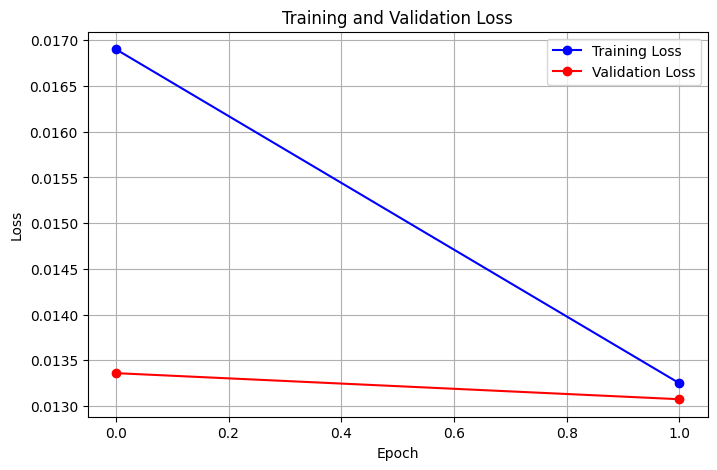

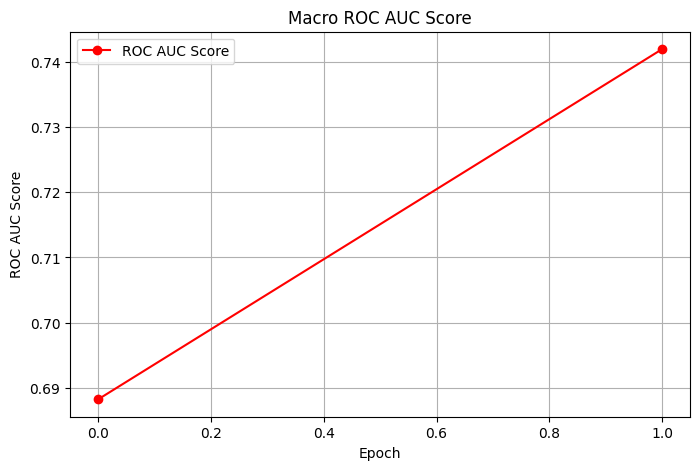

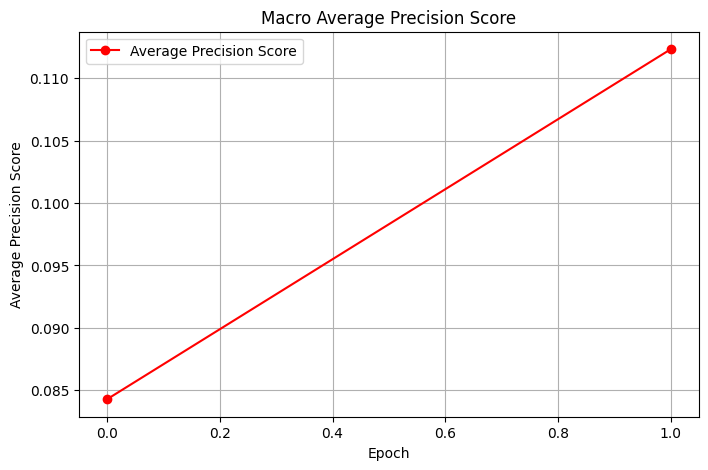


--- Starting Fold 2/5 ---
  --> Epoch 1: Best Average Precision Updated: 0.0823
Epoch 1 Train_loss: 0.0170 | Val_Loss: 0.0133 | Val_AUC: 0.6735| Val_avg_prec: 0.0823
  --> Epoch 2: Best Average Precision Updated: 0.1047
Epoch 2 Train_loss: 0.0134 | Val_Loss: 0.0129 | Val_AUC: 0.7282| Val_avg_prec: 0.1047
Generating OOF predictions for Fold 2...
Saved best model for Fold 1 to best_model_fold_1.pth


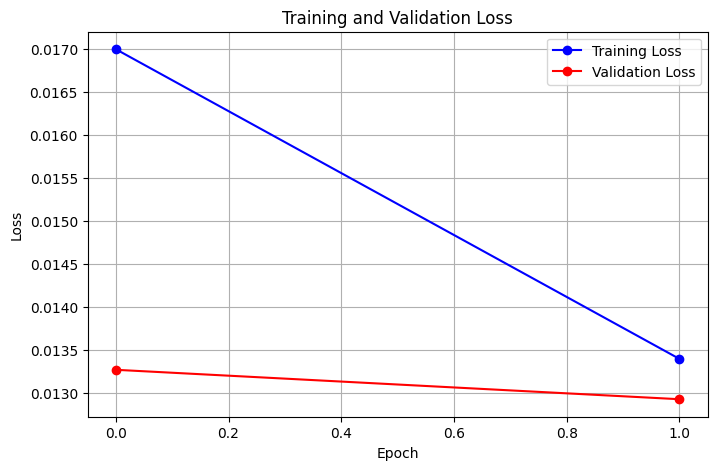

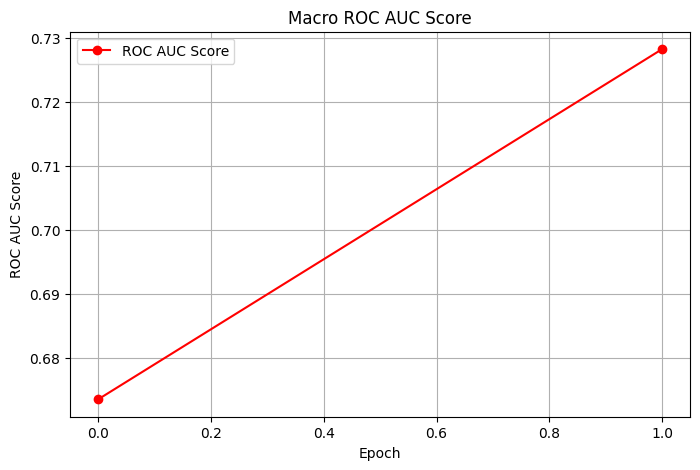

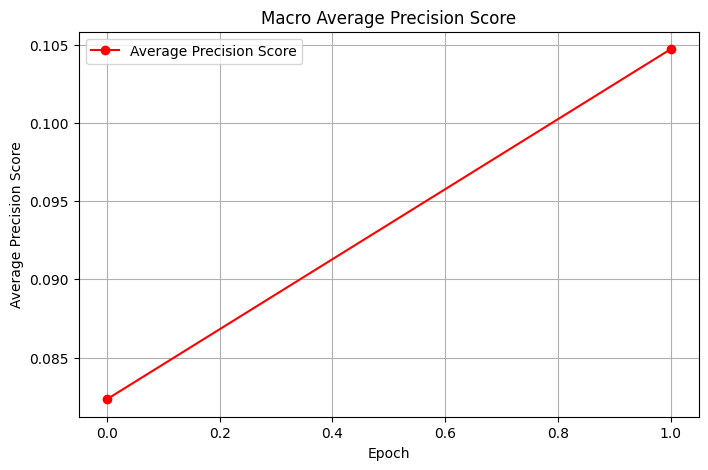


--- Starting Fold 3/5 ---
  --> Epoch 1: Best Average Precision Updated: 0.0922
Epoch 1 Train_loss: 0.0170 | Val_Loss: 0.0133 | Val_AUC: 0.6798| Val_avg_prec: 0.0922
  --> Epoch 2: Best Average Precision Updated: 0.1066
Epoch 2 Train_loss: 0.0133 | Val_Loss: 0.0133 | Val_AUC: 0.7196| Val_avg_prec: 0.1066
Generating OOF predictions for Fold 3...
Saved best model for Fold 2 to best_model_fold_2.pth


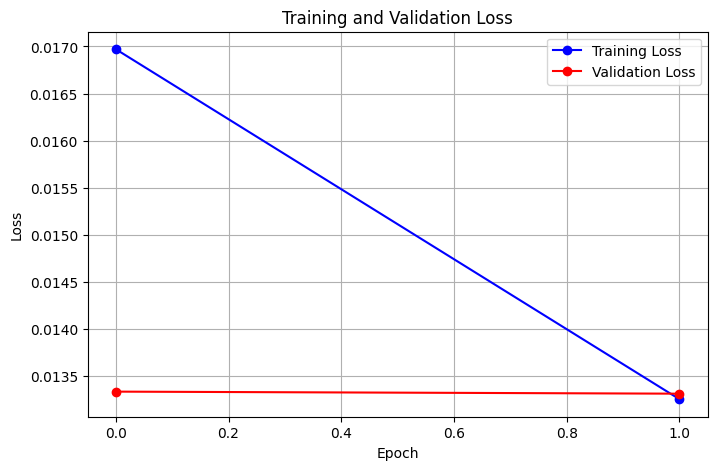

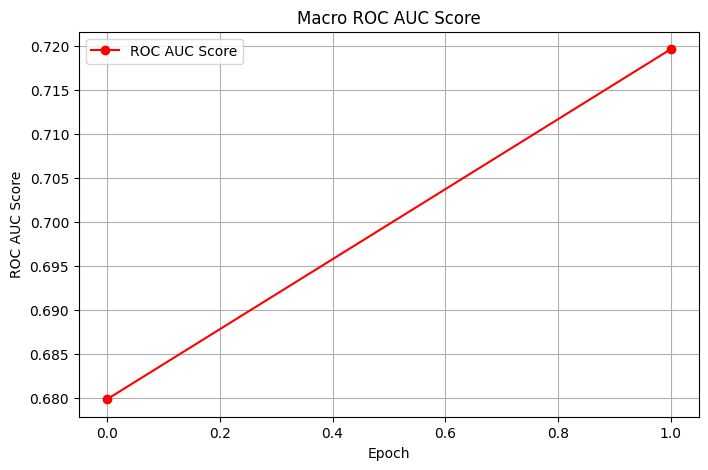

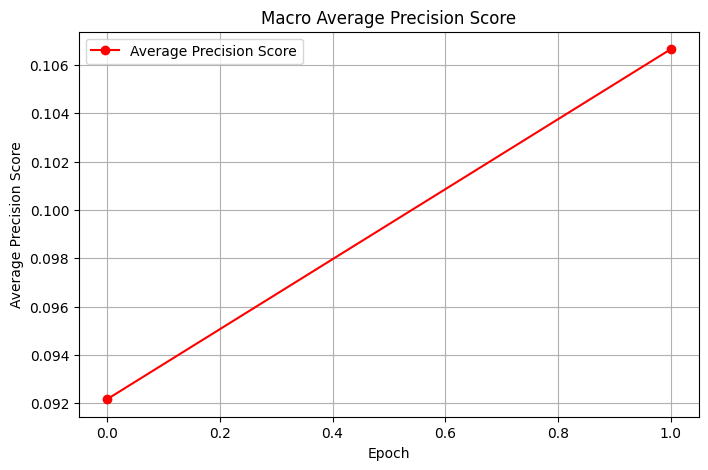


--- Starting Fold 4/5 ---
  --> Epoch 1: Best Average Precision Updated: 0.0837
Epoch 1 Train_loss: 0.0170 | Val_Loss: 0.0137 | Val_AUC: 0.6687| Val_avg_prec: 0.0837
  --> Epoch 2: Best Average Precision Updated: 0.1058
Epoch 2 Train_loss: 0.0133 | Val_Loss: 0.0133 | Val_AUC: 0.7257| Val_avg_prec: 0.1058
Generating OOF predictions for Fold 4...
Saved best model for Fold 3 to best_model_fold_3.pth


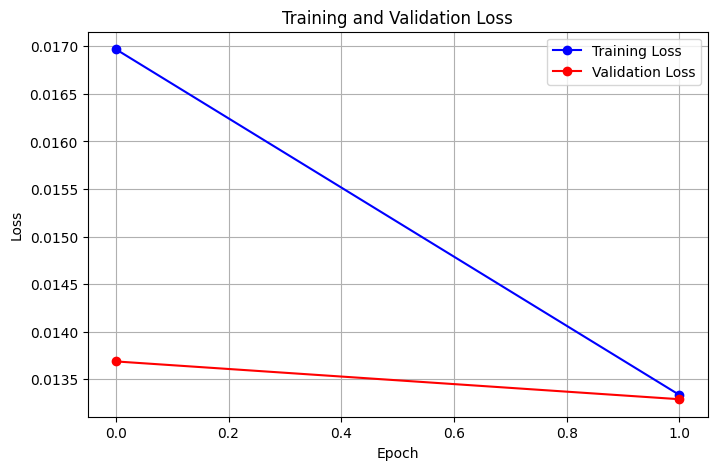

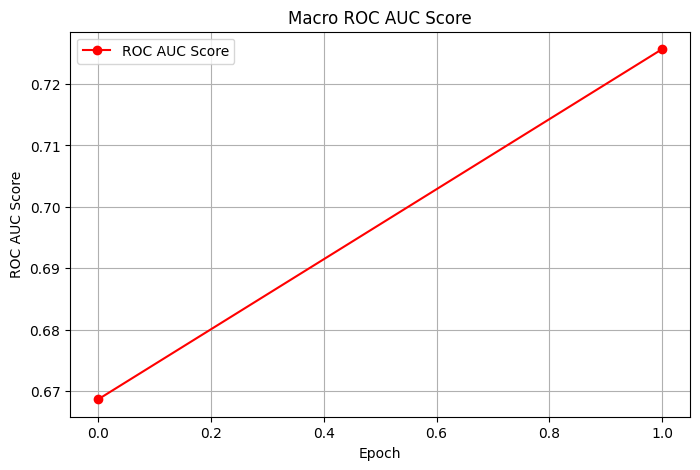

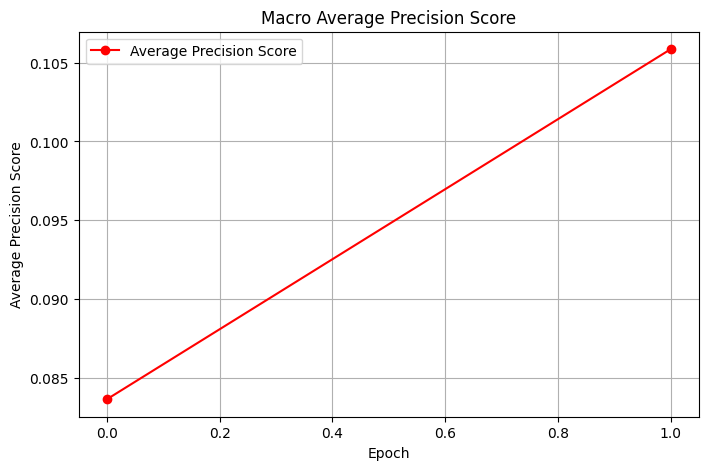


--- Starting Fold 5/5 ---
  --> Epoch 1: Best Average Precision Updated: 0.0869
Epoch 1 Train_loss: 0.0171 | Val_Loss: 0.0134 | Val_AUC: 0.6826| Val_avg_prec: 0.0869
  --> Epoch 2: Best Average Precision Updated: 0.1127
Epoch 2 Train_loss: 0.0134 | Val_Loss: 0.0129 | Val_AUC: 0.7341| Val_avg_prec: 0.1127
Generating OOF predictions for Fold 5...
Saved best model for Fold 4 to best_model_fold_4.pth


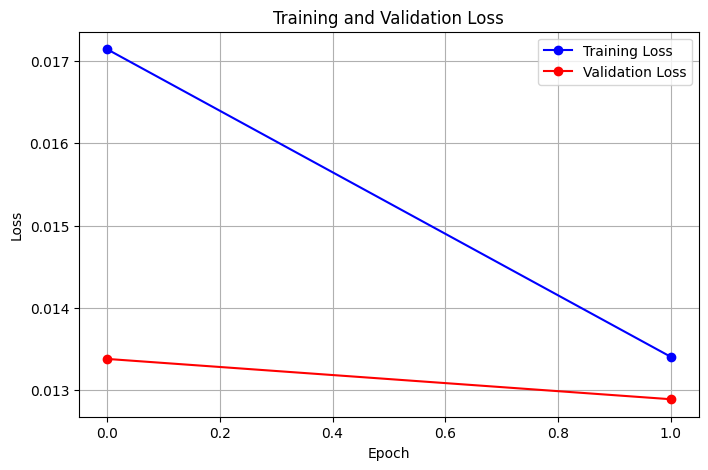

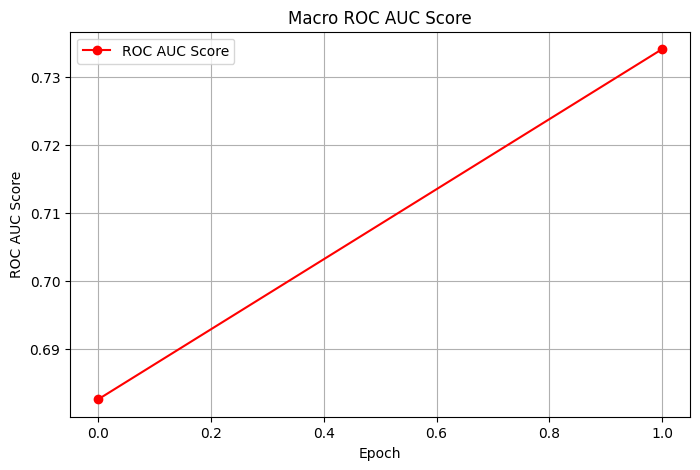

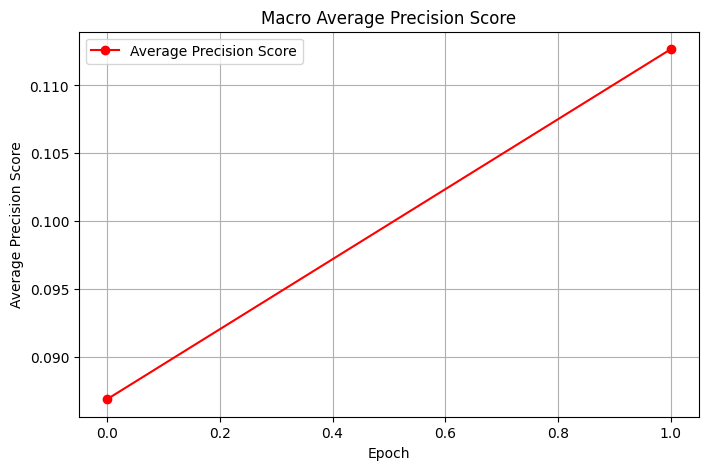

Cross-Validation complete.


In [19]:
import numpy as np
from torch.utils.data import DataLoader, Subset
from skmultilearn.model_selection import IterativeStratification

# Define the K-Fold splitter
k_folds = 5
stratifier = IterativeStratification(n_splits=k_folds, order=1)

# Initialize indices
indices = np.arange(len(ts_train))

# Store results for Out-of-fold (OOF) analysis
oof_probs = np.zeros(species_train.shape)

for fold, (train_idx, val_idx) in enumerate(stratifier.split(ts_train, species_train)):
    print(f"\n--- Starting Fold {fold+1}/{k_folds} ---")

    # Initial DataLoader setup using split=None
    full_train_data = GeoPlantDataset(timeseries=ts_train, labels=species_train, split=None)
    train_loader = DataLoader(Subset(full_train_data, train_idx), batch_size=32, shuffle=True)
    val_loader = DataLoader(Subset(full_train_data, val_idx), batch_size=32, shuffle=False)

    # 3. Initialize fresh model for every fold
    model = TimeseriesEncoder().to(device)
    criterion = MultiLabelFocalLoss(gamma=2.0, alpha=0.25)
    optimizer = torch.optim.AdamW(model.parameters())
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    EPOCHS = 2
    best_val_avg_prec = 0
    best_model_state = None

    train_loss_list = []
    val_loss_list = []
    macro_auc_list = []
    macro_avg_prec_list = []

    for epoch in range(EPOCHS):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device=device)
        val_auc, val_avg_prec, val_loss = evaluate(model, val_loader, criterion, device=device)

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        macro_auc_list.append(val_auc)
        macro_avg_prec_list.append(val_avg_prec)

        scheduler.step(val_loss)

        if  val_avg_prec > best_val_avg_prec:
            best_val_avg_prec = val_avg_prec
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            print(f"  --> Epoch {epoch+1}: Best Average Precision Updated: {val_avg_prec:.4f}")

        print(f"Epoch {epoch+1} Train_loss: {train_loss:.4f} | Val_Loss: {val_loss:.4f} | Val_AUC: {val_auc:.4f}| Val_avg_prec: {val_avg_prec:.4f}")

    # OOF Predictions
    print(f"Generating OOF predictions for Fold {fold+1}...")
    model.load_state_dict(best_model_state)
    model.eval()

    fold_preds = []
    with torch.no_grad():
        for ts, _ in val_loader:
            logits = model(ts.to(device))
            probs = torch.sigmoid(logits)
            fold_preds.append(probs.cpu().numpy())

    # Store predictions in the indices corresponding to this validation fold
    oof_probs[val_idx] = np.concatenate(fold_preds, axis=0)

    model_path = f"best_model_fold_{fold}.pth"
    torch.save(best_model_state, model_path)
    print(f"Saved best model for Fold {fold} to {model_path}")

    plt.figure(figsize=(8,5))
    plt.plot(train_loss_list, label='Training Loss', color='blue', marker='o')
    plt.plot(val_loss_list, label='Validation Loss', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    image_path = f"Models/Landsat_timeseries/Fold_{fold}_loss.png"
    plt.savefig(image_path, dpi=300)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(macro_auc_list, label='ROC AUC Score', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('ROC AUC Score')
    plt.title('Macro ROC AUC Score')
    plt.legend()
    plt.grid(True)
    image_path_ROC_AUC = f"Models/Landsat_timeseries/Fold_{fold}_ROC_AUC.png"
    plt.savefig(image_path_ROC_AUC, dpi=300)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(macro_avg_prec_list, label='Average Precision Score', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Precision Score')
    plt.title('Macro Average Precision Score')
    plt.legend()
    plt.grid(True)
    Image_path_avg_prec = f"Models/Landsat_timeseries/Fold_{fold}_avg_prec.png"
    plt.savefig(Image_path_avg_prec, dpi=300)
    plt.show()


print("Cross-Validation complete.")

## 5. Test the model

In [20]:
def ensemble_predictions(model, loader, weight_paths, device="cuda"):
    """
    1. Loads each fold model.
    2. Generates probabilities for the test set.
    3. Averages them (Ensembling).
    """
    model.to(device)
    all_fold_probs = []
    test_labels = []

    for fold_idx, path in enumerate(weight_paths):
        print(f"--> Processing Fold {fold_idx} weights...")

        # Load the saved state dict
        model.load_state_dict(torch.load(path, map_location=device, weights_only=True))
        model.eval()

        fold_probs = []
        with torch.no_grad():
            for img, y in loader:
                img = img.to(device).float()

                # Get logits and convert to probabilities
                logits = model(img)
                probs = torch.sigmoid(logits)

                fold_probs.append(probs.cpu().numpy())

                # Only collect labels once
                if fold_idx == 0:
                    test_labels.append(y.numpy())

        # Combine batches for this specific fold
        all_fold_probs.append(np.concatenate(fold_probs, axis=0))

    # Average probabilities across all folds
    ensemble_probs = np.mean(all_fold_probs, axis=0)

    # Final labels for metric calculation
    final_labels = np.concatenate(test_labels, axis=0)

    return ensemble_probs, final_labels

In [21]:
# List saved model files
fold_weight_files = [f"best_model_fold_{i}.pth" for i in range(5)]

# Generate the ensemble probabilities
ensemble_probs, test_labels = ensemble_predictions(
    model=TimeseriesEncoder(),
    loader=test_loader,
    weight_paths=fold_weight_files,
    device=device
)

--> Processing Fold 0 weights...
--> Processing Fold 1 weights...
--> Processing Fold 2 weights...
--> Processing Fold 3 weights...
--> Processing Fold 4 weights...


## 6. Evaluate the model

### 6.1 Finding best threshold using OOF analysis

In [22]:
def find_optimal_thresholds(y_true, oof_probs):
    """
    Finds the best threshold for each of the 342 species.
    y_true: Ground truth labels (N, 342)
    oof_probs: Out-of-fold predictions (N, 342)
    """
    num_species = y_true.shape[1]
    best_thresholds = np.zeros(num_species)

    # Range of thresholds to test
    thresholds = np.linspace(0, 1, 100)

    print("Optimizing thresholds for 342 species...")

    for i in range(num_species):
        species_labels = y_true[:, i]
        species_probs = oof_probs[:, i]

        # Default to 0.5
        if species_labels.sum() == 0:
            best_thresholds[i] = 0.5
            continue

        best_fbeta = -1
        best_thresh = 0.5

        for t in thresholds:
            preds = (species_probs >= t).astype(int)
            score = fbeta_score(species_labels, preds, beta=0.5, zero_division=0) # Use fbeta to raise precision

            if score > best_fbeta:
                best_fbeta = score
                best_thresh = t

        best_thresholds[i] = best_thresh

    print("Optimization complete.")
    return best_thresholds

In [23]:
opt_thresholds = find_optimal_thresholds(species_train, oof_probs)
binary_preds = (ensemble_probs >= opt_thresholds).astype(int)

Optimizing thresholds for 342 species...
Optimization complete.


### 6.2 Fully evaluating the model

In [24]:
def full_evaluation(preds, labels, opt_thresholds, binary_preds):
    macro_auc = roc_auc_score(labels, preds, average='macro')
    weighted_auc = roc_auc_score(labels, preds, average='weighted')

    macro_avg_prec = average_precision_score(labels, preds, average='macro')
    weighted_avg_prec = average_precision_score(labels, preds, average='weighted')

    macro_f1 = f1_score(labels, binary_preds, average='macro')
    weighted_f1 = f1_score(labels, binary_preds, average='weighted')

    macro_precision = precision_score(labels, binary_preds, average='macro', zero_division=0)
    weighted_precision = precision_score(labels, binary_preds, average='weighted', zero_division=0)

    macro_recall = recall_score(labels, binary_preds, average='macro')
    weighted_recall = recall_score(labels, binary_preds, average='weighted')

    subset_acc = (binary_preds == labels).all(axis=1).mean()

    rank_loss = label_ranking_loss(labels, preds)

    return {
        "Macro auc": macro_auc,
        "Weighted auc": weighted_auc,
        "Macro average precision": macro_avg_prec,
        "Weighted average precision": weighted_avg_prec,
        "Macro recall": macro_recall,
        "Weighted recall": weighted_recall,
        "Macro F1": macro_f1,
        "Weighted F1": weighted_f1,
        "Macro precision": macro_precision,
        "Weighted precision": weighted_precision,
        "Subset Accuracy": subset_acc,
        "Ranking Loss": rank_loss
    }


In [25]:
results = full_evaluation(ensemble_probs, test_labels, opt_thresholds, binary_preds)
print("Metrics for focal model:")
for k,v in results.items():
    if k != "Per-species AUCs":
        print(k, ":", v)

Metrics for focal model:
Macro auc : 0.7590256013527162
Weighted auc : 0.7603102941892523
Macro average precision : 0.12409253118596565
Weighted average precision : 0.2115457680879064
Macro recall : 0.15103483379301866
Weighted recall : 0.2284850364397581
Macro F1 : 0.09208373924709619
Weighted F1 : 0.1853262445299626
Macro precision : 0.10300858715082484
Weighted precision : 0.21026076567569982
Subset Accuracy : 0.001
Ranking Loss : 0.17735554887293695


#7. Retraining model on full training dataset using hyperparameters

In [26]:
full_train_data = GeoPlantDataset(timeseries=ts_train, labels=species_train, split=None)
full_loader = DataLoader(full_train_data, batch_size=32, shuffle=True)

# Initialize a fresh model
final_model =TimeseriesEncoder().to(device)
criterion = MultiLabelFocalLoss(gamma=2.0, alpha=0.25)
optimizer = torch.optim.AdamW(final_model.parameters())

final_epochs = 30

print(f"Starting final retraining on 100% of data for {final_epochs} epochs...")

final_model.train()
for epoch in range(final_epochs):
    train_loss = train_epoch(final_model, full_loader, optimizer, criterion, device=device)
    print(f"Epoch {epoch+1}/{final_epochs} | Loss: {train_loss:.4f}")

torch.save(final_model.state_dict(), "Models/Landsat_timeseries/Landsat_timeseries_model.pth")

Starting final retraining on 100% of data for 30 epochs...
Epoch 1/30 | Loss: 0.0163
Epoch 2/30 | Loss: 0.0132
Epoch 3/30 | Loss: 0.0129
Epoch 4/30 | Loss: 0.0128
Epoch 5/30 | Loss: 0.0126
Epoch 6/30 | Loss: 0.0125
Epoch 7/30 | Loss: 0.0124
Epoch 8/30 | Loss: 0.0123
Epoch 9/30 | Loss: 0.0122
Epoch 10/30 | Loss: 0.0121
Epoch 11/30 | Loss: 0.0121
Epoch 12/30 | Loss: 0.0120
Epoch 13/30 | Loss: 0.0120
Epoch 14/30 | Loss: 0.0119
Epoch 15/30 | Loss: 0.0118
Epoch 16/30 | Loss: 0.0118
Epoch 17/30 | Loss: 0.0117
Epoch 18/30 | Loss: 0.0117
Epoch 19/30 | Loss: 0.0116
Epoch 20/30 | Loss: 0.0115
Epoch 21/30 | Loss: 0.0114
Epoch 22/30 | Loss: 0.0114
Epoch 23/30 | Loss: 0.0113
Epoch 24/30 | Loss: 0.0113
Epoch 25/30 | Loss: 0.0112
Epoch 26/30 | Loss: 0.0111
Epoch 27/30 | Loss: 0.0111
Epoch 28/30 | Loss: 0.0111
Epoch 29/30 | Loss: 0.0109
Epoch 30/30 | Loss: 0.0109


In [27]:
def test_merged_model(model, loader, device="cuda"):
    model.eval()
    merged_probs = []
    labels = []

    with torch.no_grad():
        for env, y in loader:

            env = env.to(device).float()

            logits = model(env)
            probs = torch.sigmoid(logits)

            merged_probs.append(probs.cpu())
            labels.append(y)

    merged_probs = torch.cat(merged_probs).numpy()
    labels = torch.cat(labels).numpy()

    return merged_probs, labels

In [28]:
merged_model_probs, test_labels = test_merged_model(model=final_model, loader=test_loader, device=device)

In [29]:
merged_model_binary_preds = (merged_model_probs >= opt_thresholds).astype(int)

In [30]:
results = full_evaluation(merged_model_probs, test_labels, opt_thresholds, merged_model_binary_preds)
print("Metrics for focal model:")
for k,v in results.items():
    print(k, ":", v)

Metrics for focal model:
Macro auc : 0.8207659166684795
Weighted auc : 0.8083315676251105
Macro average precision : 0.18870323459854554
Weighted average precision : 0.27063853849084873
Macro recall : 0.503664386951093
Weighted recall : 0.5218638548612188
Macro F1 : 0.20515005417582052
Weighted F1 : 0.29770476053486816
Macro precision : 0.150598519959222
Weighted precision : 0.23529897002457
Subset Accuracy : 0.0
Ranking Loss : 0.13172523256507485


In [ ]:
# Calculate F1 per species
from sklearn.metrics import f1_score
per_species_f1 = f1_score(test_labels, binary_preds, average=None, zero_division=0)

# Sort them
sorted_indices = np.argsort(per_species_f1)[::-1]

print("Top 5 Species F1:", per_species_f1[sorted_indices[:5]])
print("Bottom 5 Species F1:", per_species_f1[sorted_indices[-5:]])
print("Number of species with 0.0 F1:", np.sum(per_species_f1 == 0))

Top 5 Species F1: [0.57142857 0.55172414 0.49275362 0.48837209 0.48229342]
Bottom 5 Species F1: [0. 0. 0. 0. 0.]
Number of species with 0.0 F1: 110


### Multilabel confusion matrix

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

# Assuming y_true and y_pred_bin are your binary matrices
binary_preds = (ensemble_probs >= opt_thresholds).astype(int)
matrices = multilabel_confusion_matrix(test_labels, binary_preds)

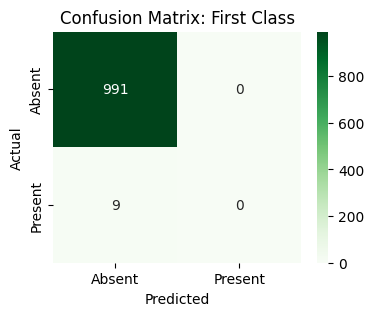

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


first_class_matrix = matrices[9]
first_class_name = "First Class"

# 3. Plot it
plt.figure(figsize=(4, 3))
sns.heatmap(first_class_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Absent', 'Present'],
            yticklabels=['Absent', 'Present'])

plt.title(f"Confusion Matrix: {first_class_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 7. Visualization on map

In [ ]:
def map_predictions_species(preds, labels, species_index, test_lats, test_lons, show_types=None):
    """
    Creates a Folium map showing prediction correctness for a specific species.

    Parameters:
    - all_preds: np.array of shape (num_samples, num_species), model predictions (0/1)
    - all_labels: np.array of shape (num_samples, num_species), true labels (0/1)
    - species_index: int, index of the species to visualize
    - test_lats: list or array of latitude values
    - test_lons: list or array of longitude values
    - show_types: set of strings indicating which prediction types to show.
                  Options: 'TP', 'TN', 'FP', 'FN'
                  Default: None (show all)
    """

    print("Number of species prediction:")
    print(preds[:,species_index].sum())
    print("Number of species occurence:")
    print(abels[:,species_index].sum())

    if show_types is None:
        show_types = {'TP', 'TN', 'FP', 'FN'}  # show all by default

    center_lat = np.mean(test_lats)
    center_lon = np.mean(test_lons)
    fmap = folium.Map(location=[center_lat, center_lon], zoom_start=4)

    preds_species = preds[:, species_index]
    labels_species = labels[:, species_index]

    for lat, lon, pred, label in zip(test_lats, test_lons, preds_species, labels_species):
        # Determine prediction type and color
        if pred == 1 and label == 1:
            pred_type = 'TP'
            color = 'green'
        elif pred == 0 and label == 1:
            pred_type = 'FN'
            color = 'red'
        elif pred == 0 and label == 0:
            pred_type = 'TN'
            color = 'blue'
        else:  # pred == 1 and label == 0
            pred_type = 'FP'
            color = 'orange'

        if pred_type not in show_types:
            continue  # skip this point if not in selected types

        folium.CircleMarker(
            location=[lat, lon],
            radius=4,
            color=color,
            fill=True,
            fill_opacity=0.6
        ).add_to(fmap)

    return fmap

In [ ]:
map_predictions_species(preds=binary_preds, labels=test_labels, species_index=30, test_lats=test_lats, test_lons=test_lons)

NameError: name 'test_lats' is not defined